Exploratory analysis of batch results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import division

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import tarfile
from glob import glob

from pandas.api.types import CategoricalDtype

# dirty hack for dev purposes only - when finished I will install the package properly
sys.path.insert(0, os.path.abspath(".."))
import camp_process as cpp

from ema_workbench.analysis.prim import setup_prim, Prim
from ema_workbench.analysis.cart import setup_cart, CART

from ema_workbench.analysis import dimensional_stacking, feature_scoring

from ema_workbench import (Model, RealParameter, ScalarOutcome, ema_logging,
                           perform_experiments)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

C:\UserData\takuyai\Miniconda3\envs\cimdev\lib\site-packages\ema_workbench\em_framework\optimization.py:22: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


Common settings defined below

In [3]:
sns.set_context("talk")
sns.set_style("white")

pj = os.path.join

# JoH Regional Studies submission dataset
DATA_PATH = 'D:/development/campaspe_data/2019-10-10_revision_runs/'

# FIG_PATH = "../figures/"
FIG_PATH = "../figures_revised/"

batch_files = glob(pj(DATA_PATH, '*.gz'))

seaborn_blue = '#2b7bba'

In [4]:
# Filter groupings
zone_influences = ['TAW', 'zone']
# crop_influences = ['root_depth']
crop_influences = ['__Crops_']
farm_decision = ['yield_per_Ha', '___water_use_ML', 'pumping_cost', 'gw_cap']
farm_irrigation = ['cost_per_Ha', 'irrigation_efficiency', 'head_pressure']
policy_cond = ['goulburn_allocation', 'max_drought_years']

# dry, usual, wet
cm_ = ['orange', 'm', 'g']

Collecting data...

In [5]:
# Getting baseline scenarios
baseline_fn = [fn for fn in batch_files if 'baseline' in fn][0]
baseline_indicators, baseline_scen_info = cpp.catchment_indicators(baseline_fn, timeseries=False)

baseline_c_scen = {scen_id: cpp.identify_scenario_climate(baseline_scen_info, '{}_'.format(scen_id))
                   for scen_id in range(13)
                  }

baselines_results = cpp.convert_indicators_to_pd(baseline_indicators)
baselines_results['names'] = 'baseline'

for idx in baselines_results.index:
    baselines_results.loc[idx, 'names'] = cpp.identify_scenario_climate(baseline_scen_info, idx)

In [6]:
# Manually creating input dict

# from integrated import run_funcs

# import pandas as pd
# dev = pd.read_csv("D:/development/campaspe_data/2019-10-10_revision_runs/2019-11-11_change_irrigation.csv", index_col=0)

# idetails = run_funcs.create_input_details(dev, [], {})

# with open('2019-11-11_change_irrigation_input_dict.pkl', 'wb') as pkl:
#     pickle.dump(idetails, pkl)

In [7]:
# Getting changed irrigation scenarios
# These are scenarios where all inputs are the same except climate and choice of irrigation across all zones
change_irrigation_fn = [fn for fn in batch_files if 'change_irrigation' in fn][0]
change_irrigation_indicators, change_irrigation_scen_info = cpp.catchment_indicators(change_irrigation_fn, timeseries=False)

change_irrigation_c_scen = {scen_id: cpp.identify_scenario_climate(change_irrigation_scen_info, '{}_'.format(scen_id))
                   for scen_id in range(9)
                  }

change_irrigation_results = cpp.convert_indicators_to_pd(change_irrigation_indicators)
change_irrigation_results['names'] = 'change_irrigation'

for idx in change_irrigation_results.index:
    change_irrigation_results.loc[idx, 'names'] = cpp.identify_scenario_climate(change_irrigation_scen_info, idx)

In [8]:
# change_irrigation_indicators.keys()[0]

In [9]:
other_fns = [fn for fn in batch_files if 'baseline' not in fn and 'historic' not in fn]

scenario_results = pd.DataFrame()
scenario_inputs = pd.DataFrame()
for batch_fn in tqdm(other_fns):
    catchment_indicators, scenario_info = cpp.catchment_indicators(batch_fn, timeseries=False)
    
    te = scenario_info.keys()[0]
    climate_scenario = scenario_info[te]['climate_scenario']
    
    res = cpp.convert_indicators_to_pd(catchment_indicators)
    res['names'] = climate_scenario
    scenario_results = cpp.combine_result_dfs(scenario_results, res)
    
    with tarfile.open(batch_fn) as tar:
        sampled_inputs = cpp.get_master_input(tar)
        
    scenario_inputs = cpp.combine_result_dfs(scenario_inputs, sampled_inputs)
# End for

# Give target scenarios informative names (e.g. match worst_case with "dry")
baselines_results = cpp.rename_target_scenarios(baselines_results)
change_irrigation_results = cpp.rename_target_scenarios(change_irrigation_results)

scenario_inputs = cpp.rename_target_scenarios(scenario_inputs)
scenario_results = cpp.rename_target_scenarios(scenario_results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.38s/it]


In [10]:
# other_fns = [fn for fn in batch_files if 'baseline' not in fn and 'historic' not in fn]
# catchment_indicators, scenario_info = cpp.catchment_indicators('D:/development/campaspe_data/2019-10-10_revision_runs\\2019-11-13_110300_goulb_low_dry.gz', timeseries=False)
# scenario_info

In [11]:
len(scenario_inputs)

5625

In [12]:
rst_type = CategoricalDtype(['current_restriction', 'proposed_restriction'], ordered=True)
scenario_inputs = cpp.to_category(scenario_inputs, 'policy___gw_restriction', rst_type)

In [13]:
rst_type = CategoricalDtype(['low', 'median', 'high'], ordered=True)
scenario_inputs = cpp.to_category(scenario_inputs, 'policy___goulburn_allocation_scenario', rst_type)

In [14]:
rst_type = CategoricalDtype([1, 3], ordered=True)
scenario_inputs = cpp.to_category(scenario_inputs, 'policy___gw_max_drought_years', rst_type)

rst_type = CategoricalDtype(['worst_case_rcp45_2016-2045 (dry)', 
                             'best_case_rcp45_2016-2045 (usual)',
                             'best_case_rcp45_2036-2065 (wet)'], ordered=True)
scenario_inputs = cpp.to_category(scenario_inputs, 'climate_scenario', rst_type)

In [15]:
# Additional data munging functions

def strip_irrelevant(y):
    """Remove irrelevant metrics from result DF"""
    y = (y.drop('Avg. $/ML', axis=1)
         .drop('Avg. ML', axis=1)
         .drop('Avg. Annual Profit ($)', axis=1)
         .drop('Avg. GPWUI', axis=1)
         .drop('Avg. IWUI', axis=1)
         .drop('Total Rainfall (mm)', axis=1)
         .drop('Avg. Dryland Area (Ha)', axis=1)
         .drop('Avg. ML/Ha', axis=1)
         .drop('GW Allocation Index (Proposed)', axis=1))

    return y
# End strip_irrelevant()


def rename_trigger_metrics(y):
    y['GW Allocation Index'] = y['gw_trigger_current_rules']
    y['GW Allocation Index (Proposed)'] = y['gw_trigger_proposed_rules']
    y['GW Level Change'] = y['gw_trigger_norm_dist']
    y['Avg. Annual Profit'] = y['Avg. Annual Profit ($M)']
    y['Avg. Irrigated Area'] = y['Avg. Irrigated Area (Ha)']

    y = (y.drop('gw_trigger_current_rules', axis=1)
          .drop('gw_trigger_proposed_rules', axis=1)
          .drop('gw_trigger_norm_dist', axis=1)
          .drop('Avg. Annual Profit ($M)', axis=1)
          .drop('Avg. Irrigated Area (Ha)', axis=1))

    return y
# End rename_trigger_metrics()


def get_scenario_features(x, y, verbose=True):
    """Extract features with Random Forest feature scoring."""
    if verbose:
        print("Num desirable outcomes: ", len(y[y == True]))
    
    ft_scores = feature_scoring.get_rf_feature_scores(x, y, random_state=101)
    ft_df = ft_scores[0]
    ft_df.columns = ['factor', 'ft_score']
    return ft_df
# End get_scenario_features()


def normalize_to_historic(df):
    df = df.copy()
    """Normalize results against historic results."""
    baseline_res = baseline_y.copy()
    hist_res = baseline_res.loc[baseline_res.names == 'historic', :]

    for col in df:
        if col == 'names':
            continue

        c_col = df[col]

        # GW Level proportional change is a special case
        # as it is normalized to min trigger level
        hv = hist_res[col][0]
        if col != 'GW Level Change':
            df.loc[:, col] = c_col / hv
        else:
            df.loc[:, col] = 1.0 + (c_col - hv)
        # End if
    # End for
    
    return df
# End normalize_to_historic()


def normalize_to_baseline(df):
    """Normalize results to corresponding baseline scenario."""
    df = df.copy()
    
    baseline_data = baseline_y.copy()

    not_name_cols = [col for col in baseline_data.columns if col != 'names']
    for scen in baseline_data['names']:
        tgt_rows = df.names.isin([scen])
        
        tgt_cols = baseline_data.loc[baseline_data.names.isin([scen]), not_name_cols]
        tgt_subset = df.loc[tgt_rows, not_name_cols]

        for col in not_name_cols:
            baseline_value = tgt_cols[col][0]
            
            if col != 'GW Level Change':
                tgt_subset.loc[:, col] = tgt_subset[col] / baseline_value
            else:
                tgt_subset.loc[:, col] = 1.0 + (tgt_subset[col] - baseline_value)
                
            df.loc[tgt_rows, col] = tgt_subset.loc[:, col]
            
        # End for
    # End for
    
    return df
# End normalize_to_baseline()


def consistent_col_order(df):
    """Reorder results into consistent column order."""
    
    order = ['Avg. Annual Profit', 'Income Volatility', 'Avg. Irrigated Area', 
             'Total SW Used (ML)', 'Total GW Used (ML)', 'SW Allocation Index', 'GW Allocation Index',
             'GW Level Change', 'Ecology Index', 'Recreation Index', 'names']

    df = df[order]
    return df
# End consistent_col_order


def remove_unneeded(scenario_inputs, unneeded):
    """Remove unneeded input factors for consideration.
    
    Always removes 'climate_scenario' column.
    
    Parameters
    ----------
    * unneeded : list[str], of column names to remove
    
    Returns
    ----------
    * x : copy of modified DF
    """
    x = scenario_inputs.copy()
    
    x = (x.pipe(cpp.strip_constants, 
                cpp.determine_constant_factors(x, verbose=False))
            .pipe(cpp.ensure_str_type)
            .pipe(cpp.remove_matches, unneeded))
    
    return x
# End remove_unneeded()


def to_recs(x):
    x_tmp = x.to_records(index=False)
    x_tmp.dtype.names = list(str(n) for n in x_tmp.dtype.names)
    
    col = 'climate_scenario'
    if col in x_tmp.dtype.names:
        x_tmp['climate_scenario'][x_tmp['climate_scenario'] == 'worst_case_rcp45_2016-2045 (dry)'] = 0
        x_tmp['climate_scenario'][x_tmp['climate_scenario'] == 'best_case_rcp45_2016-2045 (usual)'] = 1
        x_tmp['climate_scenario'][x_tmp['climate_scenario'] == 'best_case_rcp45_2036-2065 (wet)'] = 2
    
    col = 'policy___gw_restriction'
    if col in x_tmp.dtype.names:
        x_tmp['policy___gw_restriction'][x_tmp['policy___gw_restriction'] == 'current_restriction'] = 0
        x_tmp['policy___gw_restriction'][x_tmp['policy___gw_restriction'] == 'proposed_restriction'] = 1
    
    col = 'policy___goulburn_allocation_scenario'
    if col in x_tmp.dtype.names:
        x_tmp[col][x_tmp[col] == 'low'] = 0
        x_tmp[col][x_tmp[col] == 'median'] = 1
        x_tmp[col][x_tmp[col] == 'high'] = 2
    
    return x_tmp
# End to_recs()


def filter_ins(scenario_inputs, remove_ins):
    """Filter inputs"""
    x = remove_unneeded(scenario_inputs, remove_ins)
    x_tmp = to_recs(x)
    
    return x_tmp
# End filter_ins()


def filter_outs(y, remove_outs):
    """Filter outputs"""
    query_str = ' & '.join('`{}` {} {}'.format(col, op, val) for (col, op, val) in remove_outs)
    return y.eval(query_str)
# End filter_outs()


def select_desired(df):
    df = ((df["Avg. Annual Profit"] >= 1.0) &
           (df["Income Volatility"] <= 1.0) & 
           (df["Ecology Index"] >= 1.0) & 
           (df["Recreation Index"] >= 1.0)
            # additional
           # (df["GW Level Change"] >= 1.0) & 
           # (df["Total SW Used (ML)"] <= 1.0) &
           # (df["Total GW Used (ML)"] <= 1.0)
    )
    
    return df
# End select_desired()


def select_relaxed(df):
    df = ((df["Avg. Annual Profit"] >= 1.0) & 
           # (df["Income Volatility"] <= 1.0) & 
           (df["GW Level Change"] >= 1.0) & 
           (df["Ecology Index"] >= 1.0) & 
           (df["Recreation Index"] >= 0.75)
        )
    
    return df
# End select_relaxed()

In [16]:
# Plotting functions

def plot_scenario_results(x, y, desirable_y, threshold=0.0, 
                          title_prepend='', title_y=0.99, cm=['orange', 'g', 'm'], 
                          save_pth=False):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

    ft_df = get_scenario_features(x, desirable_y)

    threshold = 0.0
    constrained = ft_df[ft_df['ft_score'] >= threshold].sort_values('ft_score', ascending=True)
    show_grouped_factors(constrained, ax=ax1)

    pd.plotting.parallel_coordinates(y[desirable_y], 'names', color=cm, alpha=0.15, ax=ax2)
    ax2.plot(ax2.get_xlim(), [1.0, 1.0], color='r', linestyle='-.', alpha=0.7, label='baseline')
    ax2.xaxis.set_tick_params(rotation=90)
    plt.legend()  # , bbox_to_anchor=(1.0, 0.5)

    title = ''
    if len(title_prepend) > 0:
        title += title_prepend+'\n'
    title += 'Desirable Scenarios\n(N = {})'.format(len(y[desirable_y]))
    plt.suptitle(title, y=title_y)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    if save_pth:
        plt.savefig(save_pth, format='png', dpi=300, bbox_inches = "tight")
    # End if
# End plot_scenario_results()


def plot_pcp(y,
             title_prepend='', title_y=0.99, cm=['orange', 'g', 'm'],
             save_pth=False):
    """Plot parallel coordinate plot."""
    plt.figure()
    ax = pd.plotting.parallel_coordinates(y, 'names', color=cm, alpha=0.15)
    ax.plot(ax.get_xlim(), [1.0, 1.0], color='r', linestyle='-.', alpha=0.7, label='baseline')
    ax.xaxis.set_tick_params(rotation=90)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    
    title = ''
    if len(title_prepend) > 0:
        title += title_prepend+'\n'
    title += 'Desirable Scenarios\n(N = {})'.format(len(y.index))
    plt.title(title, y=title_y)
    
    plt.tight_layout()
    
    if save_pth:
        # FIG_PATH+'robust_scenarios_fs_pcp.png'
        plt.savefig(save_pth, format='png', dpi=300)
    # End if
# End plot_pcp()


def show_grouped_factors(df, ax=None):
    tmp_df = df.copy()
    tmp_df = tmp_df.set_index('factor', drop=True).T
    tmp_df.columns = tmp_df.columns.str.split('___', expand=True)

    tmp_df = tmp_df.groupby(level=1, axis=1).sum().T  # .sort_values('ft_score', ascending=True).plot(kind='barh')
    tmp_df.index = tmp_df.index.str.replace("zone_", "irrigation_choice_for_zone_")

    ax = tmp_df.sort_values('ft_score', ascending=True).plot(kind='barh', legend=False, ax=ax)
    return ax
# End show_grouped_factors()

In [17]:
baseline_y = baselines_results.copy()
baseline_y = (rename_trigger_metrics(baseline_y).pipe(strip_irrelevant)
                                                .pipe(consistent_col_order))

normalized_baseline = (baseline_y.pipe(normalize_to_historic)
                                 .reset_index(drop=True))

normalized_results = (scenario_results.pipe(rename_trigger_metrics)
                                     .pipe(strip_irrelevant)
                                     .pipe(normalize_to_baseline)
                                     .pipe(consistent_col_order)
                                     .reset_index(drop=True))

normalized_to_historic = (scenario_results.pipe(rename_trigger_metrics)
                                     .pipe(strip_irrelevant)
                                     .pipe(normalize_to_historic)
                                     .pipe(consistent_col_order)
                                     .reset_index(drop=True))
                                    

normalized_to_historic.index.name = 'scenario_id'
normalized_baseline.index.name = 'scenario_id'
normalized_results.index.name = 'scenario_id'

In [18]:
len(baseline_y.index)

# len(normalized_to_historic.index)

13

In [19]:
# mung_for_adrian = (scenario_results.pipe(rename_trigger_metrics)
#                                      .pipe(strip_irrelevant)
#                                      .pipe(normalize_to_baseline)
#                                      .pipe(consistent_col_order)
#                                      .reset_index(drop=True))

# mung_for_adrian.loc[0:935].to_csv("dry_scenario_results.csv")
# scenario_inputs.loc[0:935].to_csv("dry_scenario_inputs.csv")

In [20]:
# Example of writing out inputs used and corresponding and outputs to file
# baseline_y.to_csv("baseline_results.csv")

# normalized_baseline.index = baseline_y.index
# normalized_baseline.to_csv("normalized_baseline.csv")

In [21]:
sel = scenario_inputs.columns.str.contains('Farm___zone_')
subset = scenario_inputs.loc[:, sel]

just_irrigation_inputs = scenario_inputs.loc[5616:, :]
# normalized_irrig

# Story telling begins here

Below we plot a parallel coordinate plot comparing the indicated outcomes against results from the historic (modelled) scenario

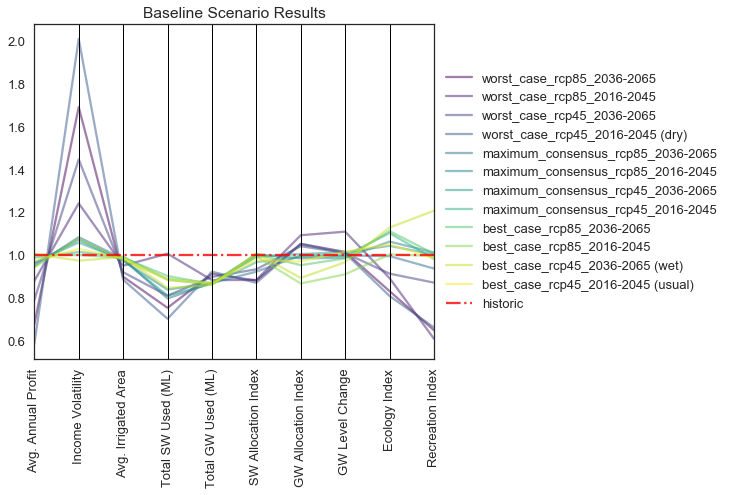

In [22]:
hist_res = normalized_baseline.loc[normalized_baseline.names == 'historic', :]
other_res = normalized_baseline.loc[normalized_baseline.names != 'historic', :]

plt.figure()
pcp_colors = plt.get_cmap('viridis')

ax = pd.plotting.parallel_coordinates(other_res.sort_values('names')[::-1], 'names', alpha=0.5, colormap=pcp_colors);
ax = pd.plotting.parallel_coordinates(hist_res, 'names', linestyle='-.', color='r', alpha=0.8, ax=ax);

plt.xticks(rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title('Baseline Scenario Results')

plt.tight_layout()
plt.savefig(FIG_PATH+'baseline_pcp.png', format='png', dpi=300)

As shown in the above - if no changes are made:

* Avg. annual farm profit is likely to decrease 
* Farmer income will become more volatile
* The `ecology` will improve under "wetter" conditions, and be further stressed under "drier" conditions
* Recreational use of the dam will similarly be spread based on climatic conditions
* More groundwater will be used under dry conditions, with most scenarios experiencing lower SW allocations

The figure below shows robust scenarios compared to historic outcomes.

There are no beneficial outcomes identified under "dry" scenarios - in other words the modelling suggests that there will be no improvement compared to current situations if extreme dry conditions become the new norm.

('Num desirable outcomes: ', 796)


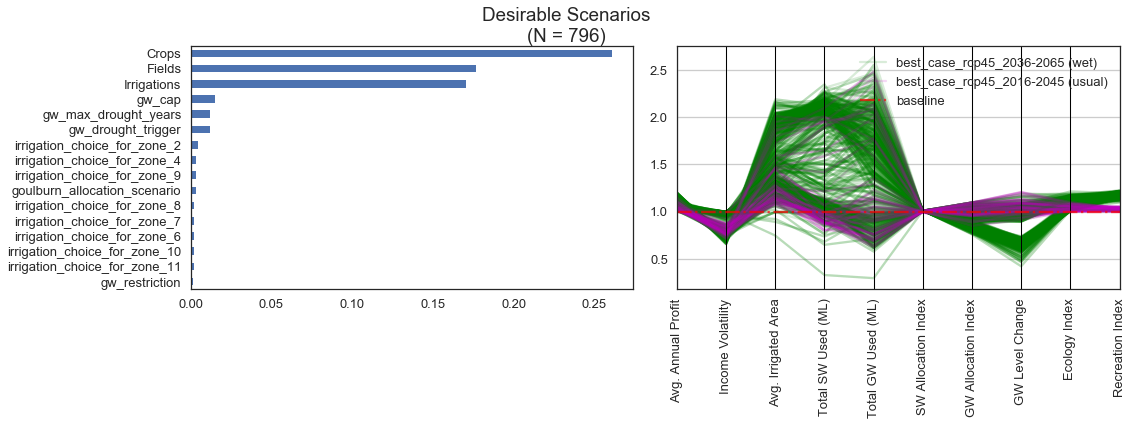

In [23]:
x_tmp = filter_ins(scenario_inputs, [])

y = normalized_to_historic.copy()
desirable_y = select_desired(y)

plot_scenario_results(x_tmp, y, desirable_y, cm=['g', 'm'],
                      save_pth=FIG_PATH+'robust_scenarios_against_historic_fs_pcp.png')

In [24]:
# ft_scores = feature_scoring.get_rf_feature_scores(x_tmp, y, random_state=101)

In [25]:
# x_tmp

Just the parallel coordinate plot from above

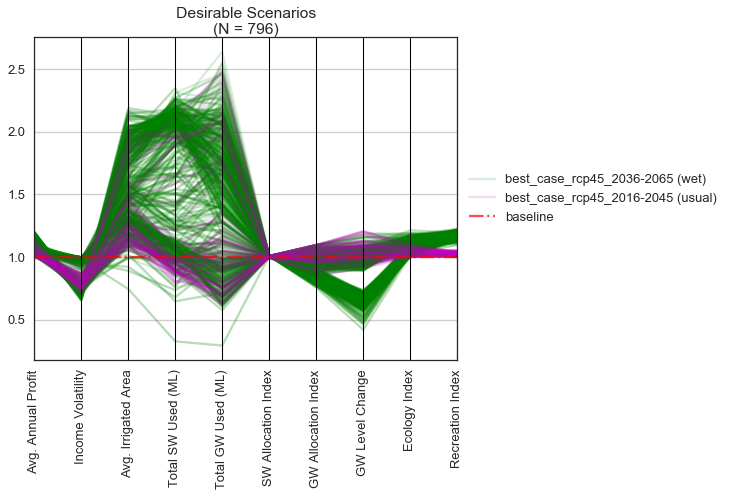

In [26]:
pcp_colors = plt.get_cmap('viridis')

y = normalized_to_historic.copy()
desirable_y = select_desired(y)
y = y[desirable_y]

plot_pcp(y, cm=['g', 'm'], title_y=0.99,
         save_pth=FIG_PATH+'robust_scenarios_against_historic_pcp.png')

Given that potentially no beneficial scenarios exist under dry conditions (compared to the historic), we then compare scenario results for each climate condition against their respective baseline.

In other words, what options induce improvements to the indicators when scenario outcomes are compared to their own baseline results (e.g. "dry" scenarios compared against the "dry" scenario baseline).

('Num desirable outcomes: ', 93)


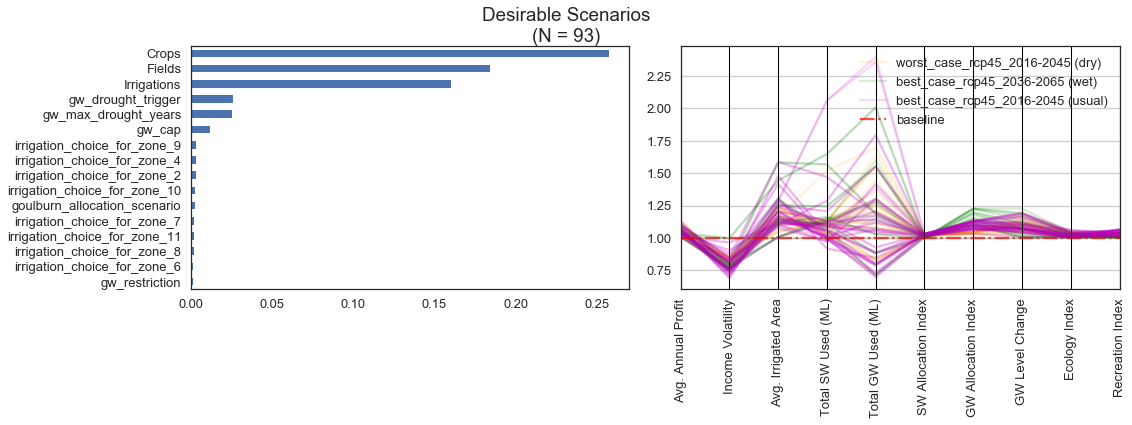

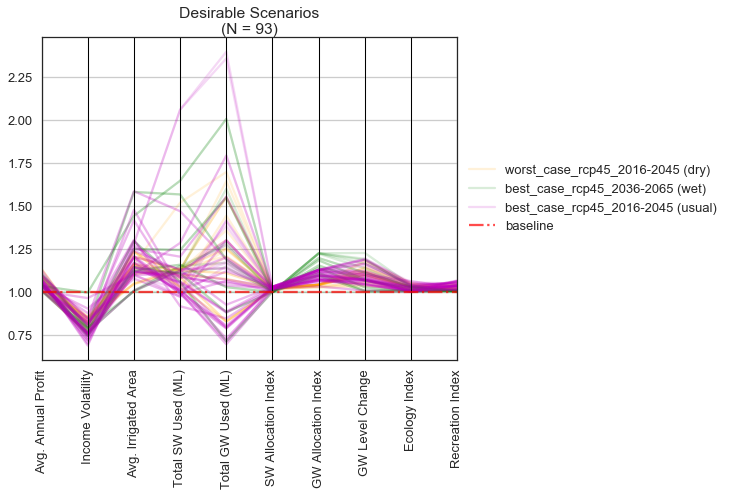

In [27]:
x_tmp = filter_ins(scenario_inputs, [])

y = normalized_results.copy()
desirable_y = select_desired(y)

plot_scenario_results(x_tmp, y, desirable_y, save_pth=FIG_PATH+'robust_against_baseline_fs_pcp.png')

y = y[desirable_y]
plot_pcp(y, title_y=0.99,
         save_pth=FIG_PATH+'robust_against_baselines_pcp.png')

('Num desirable outcomes: ', 93)


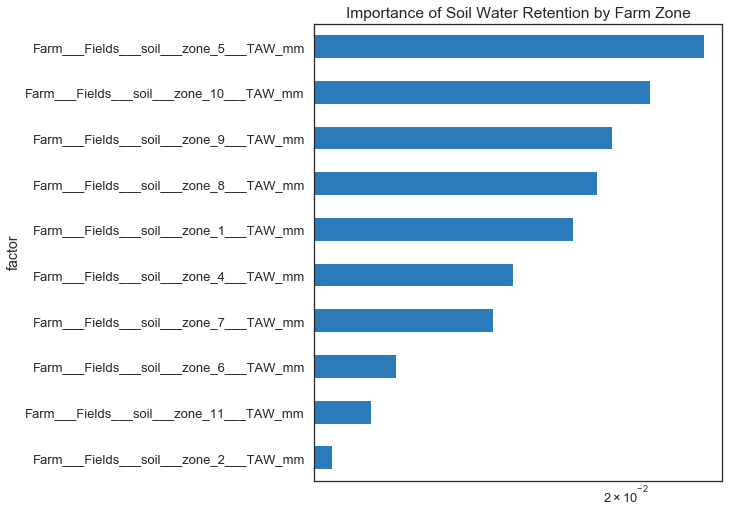

In [28]:
uncontrollable = []
unneeded = []

remove_influences = unneeded + uncontrollable

# x = remove_unneeded(scenario_inputs, remove_influences)
x_tmp = filter_ins(scenario_inputs, remove_influences)
y = normalized_results.copy()
desirable_y = select_desired(y)

ft_df = get_scenario_features(x_tmp, desirable_y)

threshold = 0.01
constrained = ft_df[ft_df['ft_score'] >= threshold].sort_values('ft_score', ascending=True)
constrained_taw = constrained.loc[constrained.factor.str.contains('TAW'), :]
constrained_taw.plot.barh(x='factor', y='ft_score', color=seaborn_blue, legend=False, logx=True);  # '#3498db'

plt.tight_layout()
plt.title("Importance of Soil Water Retention by Farm Zone")
plt.savefig(FIG_PATH+'TAW_influence_by_zone.png', dpi=300)

Results suggests such improvements to the baseline are possible.

Here, on-farm management of crops, fields, and irrigation systems are especially important towards achieving "robust" outcomes, but that policy factors also contribute.

Before we move on to the policy factors, would improving irrigation systems (in Zones 4 and 9) help achieve "robust" outcomes?

Gravity 15  | P&R: 10 | Spray: 3


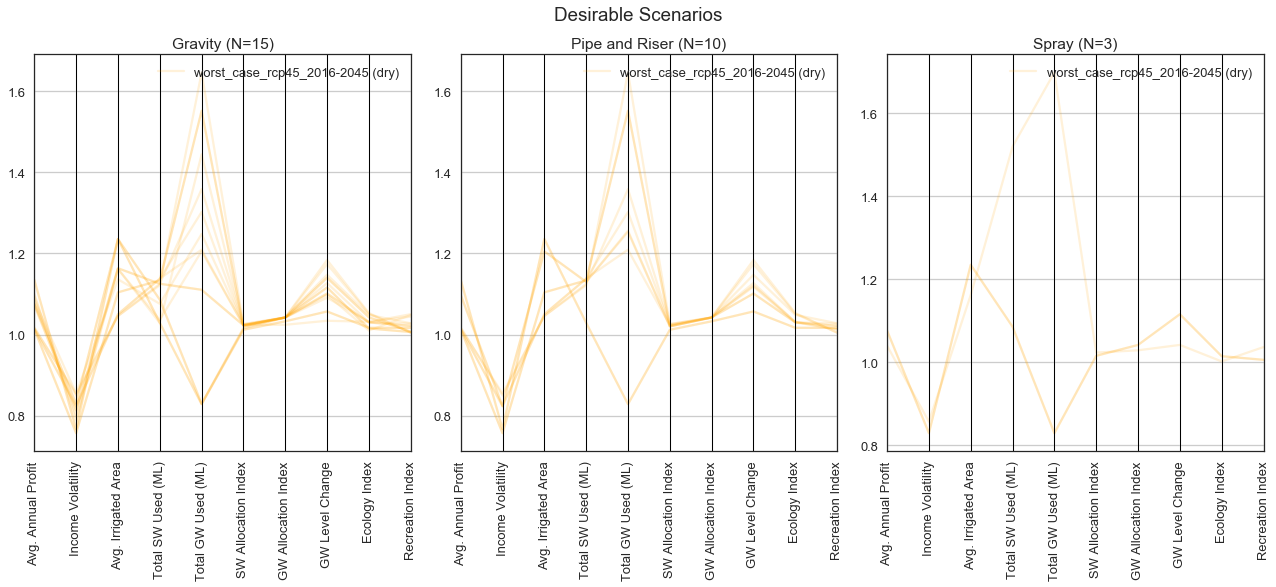

In [29]:
x = remove_unneeded(scenario_inputs, [])

gr_efficiency = x['Farm___Irrigations___Gravity___irrigation_efficiency']
gr_cost = x['Farm___Irrigations___Gravity___cost_per_Ha']
gr_sel = ( ((x['Farm___zone_4___Irrigation'] == 'Gravity') | 
            (x['Farm___zone_9___Irrigation'] == 'Gravity')) &
            ((gr_efficiency >= 0.5)) &  #  & (gr_efficiency <= 0.7)
            (x['climate_scenario'] == 'worst_case_rcp45_2016-2045 (dry)')
            #(gr_cost >= 2000.0)
           )

pr_efficiency = x['Farm___Irrigations___PipeAndRiser___irrigation_efficiency']
pr_cost = x['Farm___Irrigations___PipeAndRiser___cost_per_Ha']
pr_sel = ( ((x['Farm___zone_4___Irrigation'] == 'PipeAndRiser') | 
            (x['Farm___zone_9___Irrigation'] == 'PipeAndRiser')) &
            ((pr_efficiency >= 0.7)) &  #  & (pr_efficiency <= 0.8)
            # (pr_cost >= 2500.0)
            (x['climate_scenario'] == 'worst_case_rcp45_2016-2045 (dry)')
           )

spray_efficiency = x['Farm___Irrigations___Spray___irrigation_efficiency']
spray_cost = x['Farm___Irrigations___Spray___cost_per_Ha']
sp_sel = ( ((x['Farm___zone_4___Irrigation'] == 'Spray') |
            (x['Farm___zone_9___Irrigation'] == 'Spray')) &
            (spray_efficiency >= 0.8) & # &
            # (spray_cost >= 3000.0)
            (x['climate_scenario'] == 'worst_case_rcp45_2016-2045 (dry)')
           )

gr_idx = x.loc[gr_sel, :].index
gr_tmp = to_recs(x)
gr_tmp = gr_tmp[gr_idx]
          
pr_idx = x.loc[pr_sel, :].index
pr_tmp = to_recs(x)
pr_tmp = pr_tmp[pr_idx]

sp_idx = x.loc[sp_sel, :].index
sp_tmp = to_recs(x)
sp_tmp = sp_tmp[sp_idx]


y = normalized_results.copy()
gr_y = y.loc[gr_idx, :]
pr_y = y.loc[pr_idx, :]
sp_y = y.loc[sp_idx, :]

gr_outs = select_desired(gr_y)
pr_outs = select_desired(pr_y)
sp_outs = select_desired(sp_y)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,8))

# # dry, usual, wet
# cm_ = ['orange', 'm', 'g']

pd.plotting.parallel_coordinates(gr_y[gr_outs], 'names', color=cm_, alpha=0.15, ax=ax1)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title("Gravity (N={})".format(len(gr_y[gr_outs])))
ax1.xaxis.set_tick_params(rotation=90)
# ax1.legend([''])

pd.plotting.parallel_coordinates(pr_y[pr_outs], 'names', color=cm_, alpha=0.15, ax=ax2)
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_title("Pipe and Riser (N={})".format(len(pr_y[pr_outs])))
ax2.xaxis.set_tick_params(rotation=90)
# ax2.legend([''])

pd.plotting.parallel_coordinates(sp_y[sp_outs], 'names', color=cm_, alpha=0.15, ax=ax3)
ax3.xaxis.set_tick_params(rotation=90)
ax3.set_title("Spray (N={})".format(len(sp_y[sp_outs])))
ax3.xaxis.set_tick_params(rotation=90)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.suptitle('Desirable Scenarios', y=1.025)

plt.tight_layout()

print("Gravity {}  | P&R: {} | Spray: {}".format(len(gr_y[gr_outs]), len(pr_y[pr_outs]), len(sp_y[sp_outs])))

Improving just the irrigation systems alone across the board in non-dryland zones (i.e. all zones excluding 1, 3, 5 and 12) do not lead to any robust outcomes

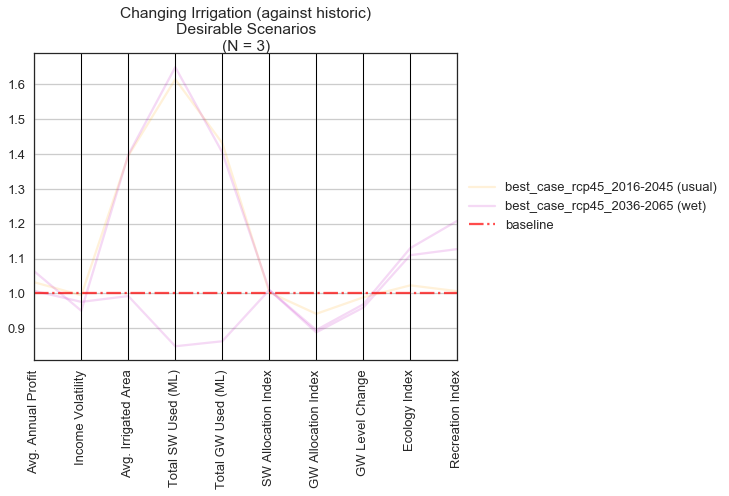

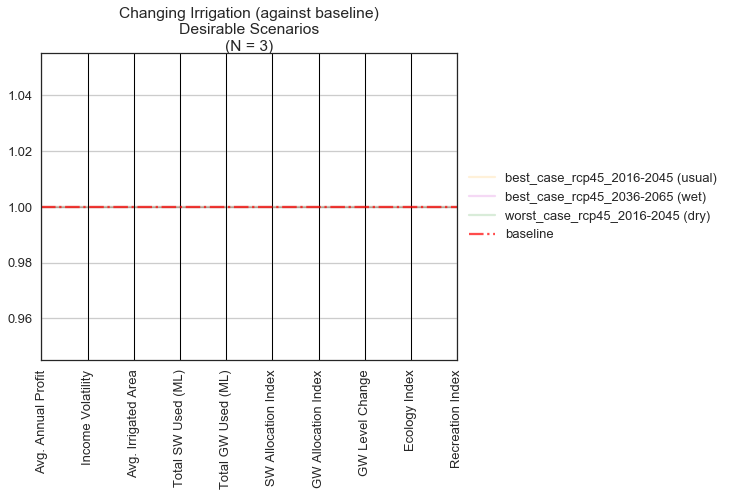

In [30]:
changed_irrig_y = change_irrigation_results.copy()
changed_irrig_y = (rename_trigger_metrics(changed_irrig_y).pipe(strip_irrelevant)
                                                          .pipe(consistent_col_order))

normalized_irrig_historic = (changed_irrig_y.pipe(normalize_to_historic)
                                 .reset_index(drop=True))
normalized_irrig_baseline = (changed_irrig_y.pipe(normalize_to_baseline)
                                 .reset_index(drop=True))

desirable_irrig_historic = select_desired(normalized_irrig_historic)
desirable_irrig_baseline = select_desired(normalized_irrig_baseline)

plot_pcp(normalized_irrig_historic[desirable_irrig_historic], cm=cm_, title_y=0.99, 
         title_prepend='Changing Irrigation (against historic)')  # save_pth=FIG_PATH+'no_robust_change_irrigation_historic.png'

plot_pcp(normalized_irrig_baseline[desirable_irrig_baseline], cm=cm_, title_y=0.99, 
         title_prepend='Changing Irrigation (against baseline)')  # save_pth=FIG_PATH+'no_robust_change_irrigation_baseline.png'

We then investigate policy factors further

('Num desirable outcomes: ', 93)


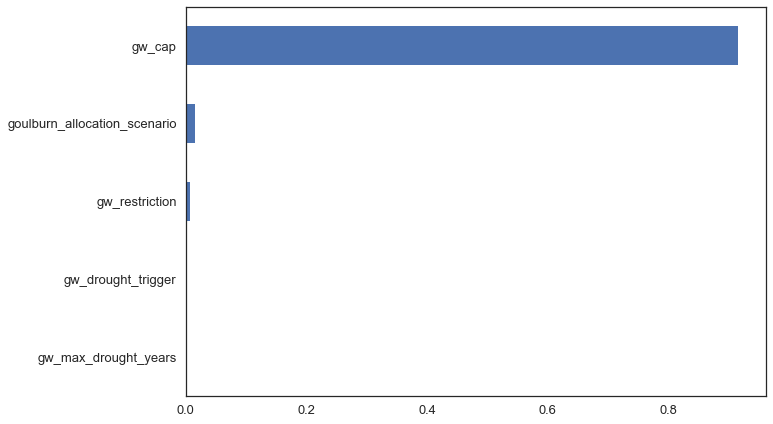

In [31]:
x_tmp = filter_ins(scenario_inputs, ['Crops__', 'Fields__', 'Irrigations__', 'zone_'])
y = normalized_results.copy()
desirable_y = select_desired(y)

ft_df = get_scenario_features(x_tmp, desirable_y)

threshold = 0.0
constrained = ft_df[ft_df['ft_score'] >= threshold].sort_values('ft_score', ascending=True)
# constrained.plot.barh(x='factor', y='ft_score', color=seaborn_blue, legend=False);

show_grouped_factors(constrained)

('Num desirable outcomes: ', 93)


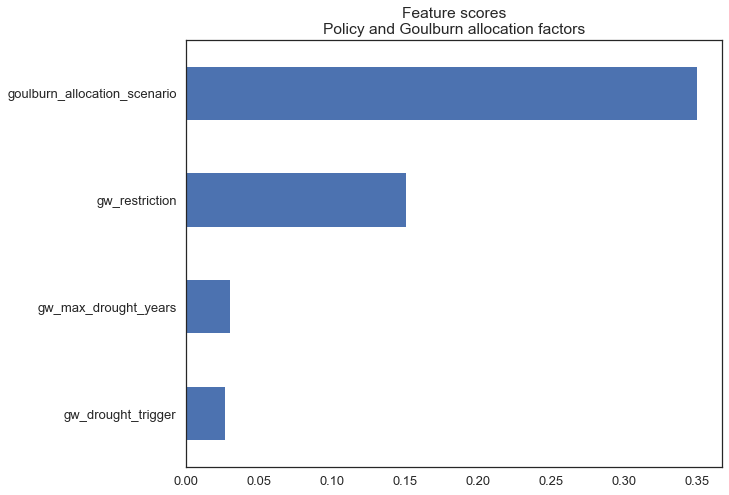

In [32]:
x_tmp = filter_ins(scenario_inputs, ['Crops__', 'Fields__', 'Irrigations__', 'zone_', 'gw_cap'])
y = normalized_results.copy()
desirable_y = select_desired(y)

ft_df = get_scenario_features(x_tmp, desirable_y)

threshold = 0.0
constrained = ft_df[ft_df['ft_score'] >= threshold].sort_values('ft_score', ascending=True)

show_grouped_factors(constrained)

plt.title("Feature scores\nPolicy and Goulburn allocation factors");
plt.tight_layout()

plt.savefig(FIG_PATH+'fs_policy_factors.png', dpi=300)

In the above plots we note two things.

Firstly, once other farm-level aspects are removed, the amount of groundwater considered for use within a season has a large effect on robust outcomes, and is identified as being more of a factor compared to policy considerations.

If we remove all farm-level related factors completely, then the amount of allocations from the Goulburn system is important - unsurprising given the volume of entitlements which Campaspe irrigators rely on.

Aside from this, the conjunctive use policy rulesets in place have a noticeable effect.

Delving deeper into the amount of groundwater to be considered, we see that up to 77% of groundwater allocations must be considered for use in order for "robust" outcomes to be experienced under all climate scenarios.

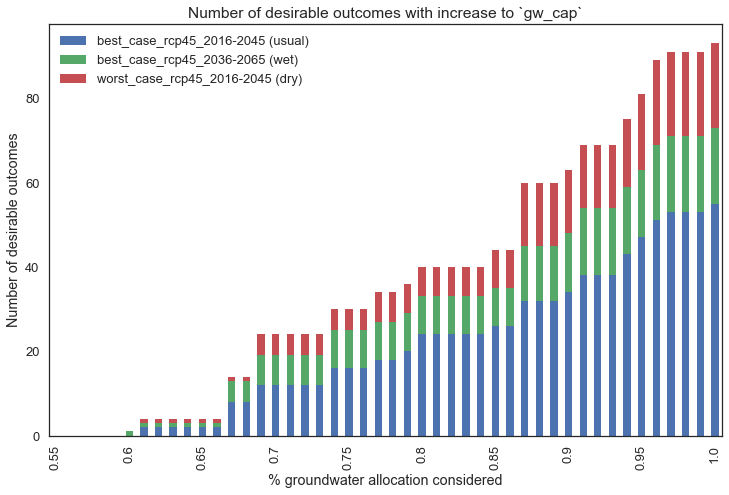

In [33]:
x = remove_unneeded(scenario_inputs, [])
num_robust_outcomes = {}
for set_cap in np.arange(0.55, 1.01, 0.01):
    y = normalized_results.copy()
    idx = x.loc[(x['policy___gw_cap'] <= set_cap), :].index
    y = y.loc[idx, :]
    desirable_y = select_desired(y)
    y_tmp = y[desirable_y]

    num_robust = y_tmp.groupby('names').size()
    num_robust_outcomes[set_cap] = num_robust.to_dict()
    
#     if (num_robust > 1).all():
#         num_robust_outcomes[set_cap] = num_robust.to_dict()
#     else:
#         for col in num_robust:
#             num_robust.values[:] = 0
#         num_robust_outcomes[set_cap] = num_robust.to_dict()

# End for

ax = pd.DataFrame(num_robust_outcomes).T.plot(kind='bar', stacked=True)
ax.set_xlabel('% groundwater allocation considered')
ax.set_ylabel('Number of desirable outcomes')
plt.title("Number of desirable outcomes with increase to `gw_cap`")

# Manually indicating point at which robust scenarios for all
# climates are found
for i, t in enumerate(ax.get_xticklabels()):
    # t.set_visible(False)
#     if ((i % 5) != 0) and i != 22:
#         t.set_visible(False)
    
    if ((i % 5) != 0):
        t.set_visible(False)
    
#     if i == 22:
#         t.set_fontweight('bold')
    
plt.tight_layout()
plt.savefig(FIG_PATH+'outcomes_with_gw_cap_increase.png', format='png', dpi=300)

In [34]:
# x = remove_unneeded(scenario_inputs, [])
# num_robust_outcomes = {}
# for set_cap in np.arange(0.55, 1.01, 0.01):
#     y = normalized_results.copy()
#     idx = x.loc[(x['policy___gw_cap'] <= set_cap), :].index
#     y = y.loc[idx, :]
#     desirable_y = select_desired(y)
#     y_tmp = y[desirable_y]

#     num_robust = y_tmp.groupby('names').size()
#     if len(num_robust.index.unique()) == 3:
#         num_robust_outcomes[set_cap] = num_robust.sum()
#     else:
#         num_robust_outcomes[set_cap] = 0
# # End for

# ax = pd.DataFrame(num_robust_outcomes, index=['Number of Scenarios']).T.plot(kind='bar', legend=False)
# ax.set_xlabel('% groundwater allocation considered')
# ax.set_ylabel('Number of robust outcomes\n(with all climate conditions)')
# plt.title("Number of robust outcomes with increase to `gw_cap`")

# # Manually indicating point at which robust scenarios for all
# # climates are found
# for i, t in enumerate(ax.get_xticklabels()):
#     if ((i % 5) != 0) and i != 22:
#         t.set_visible(False)
    
#     if i == 22:
#         t.set_fontweight('bold')

Beneficial outcomes (again, compared against their baselines) are concentrated within scenarios with a dry climate coupled with proposed conjunctive use rules.

('Num desirable outcomes: ', 93)


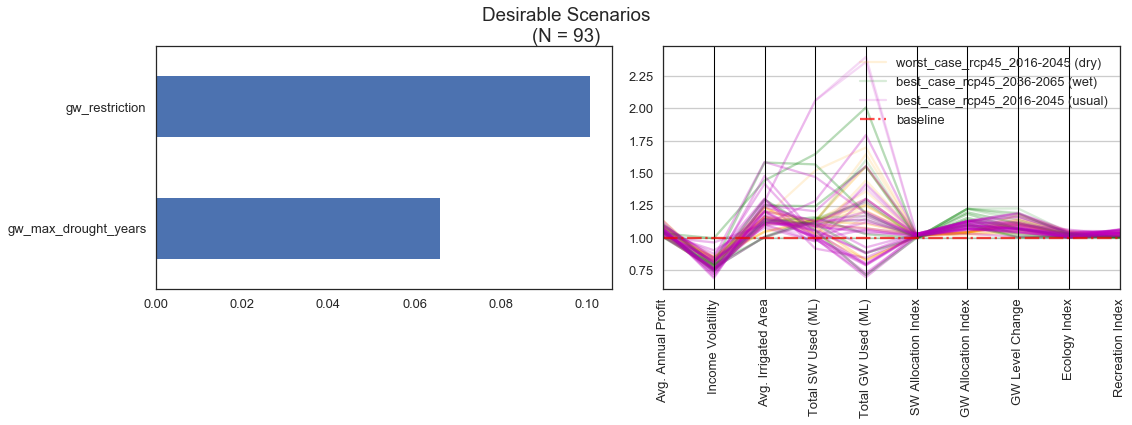

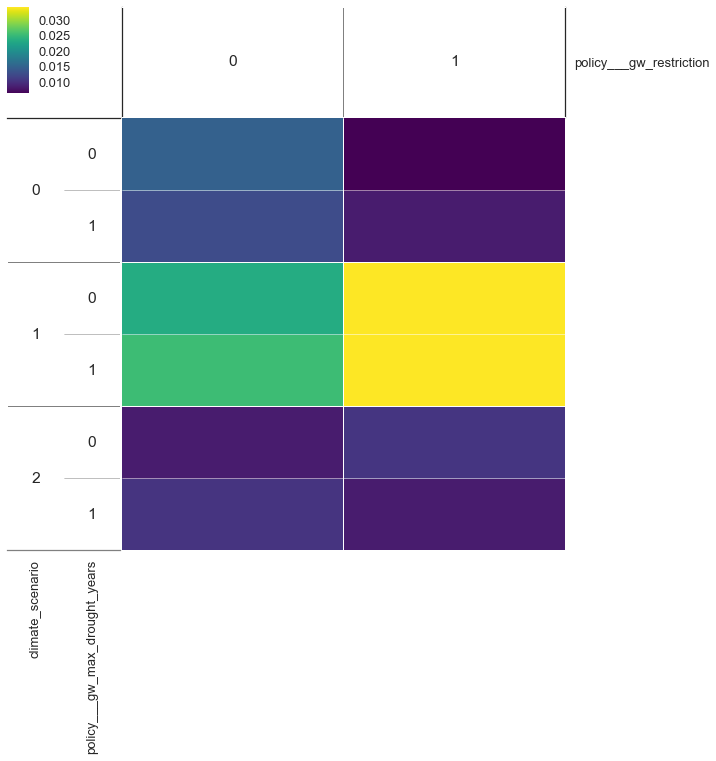

In [35]:
uncontrollable = zone_influences
unneeded = (crop_influences 
            + ['yield_per_Ha', '___water_use_ML', 'pumping_cost', 'Field', 'Irrigation']
            + ['drought_trigger', 'gw_cap', 'allocation_scenario'])

remove_influences = uncontrollable + unneeded

x_tmp = filter_ins(scenario_inputs, remove_influences)

# x_tmp['climate_scenario'][x_tmp['climate_scenario'] == 'worst_case_rcp45_2016-2045 (dry)'] = 0
# x_tmp['climate_scenario'][x_tmp['climate_scenario'] == 'best_case_rcp45_2016-2045 (usual)'] = 1
# x_tmp['climate_scenario'][x_tmp['climate_scenario'] == 'best_case_rcp45_2036-2065 (wet)'] = 2
# x_tmp['policy___gw_restriction'][x_tmp['policy___gw_restriction'] == 'current_restriction'] = 0
# x_tmp['policy___gw_restriction'][x_tmp['policy___gw_restriction'] == 'proposed_restriction'] = 1

y = normalized_results.copy()

desirable_y = select_desired(y)
plot_scenario_results(x_tmp, y, desirable_y, threshold=0.0)

dimensional_stacking.create_pivot_plot(x_tmp, desirable_y, 2, nbins=2, bin_labels=False);

In [36]:
x_tmp

rec.array([(0, 1, 1), (0, 1, 1), (0, 1, 0), ..., (0, 3, 0), (0, 3, 0),
           (0, 3, 0)], 
          dtype=[('climate_scenario', 'O'), ('policy___gw_max_drought_years', '<i8'), ('policy___gw_restriction', 'O')])

('Num desirable outcomes: ', 20)


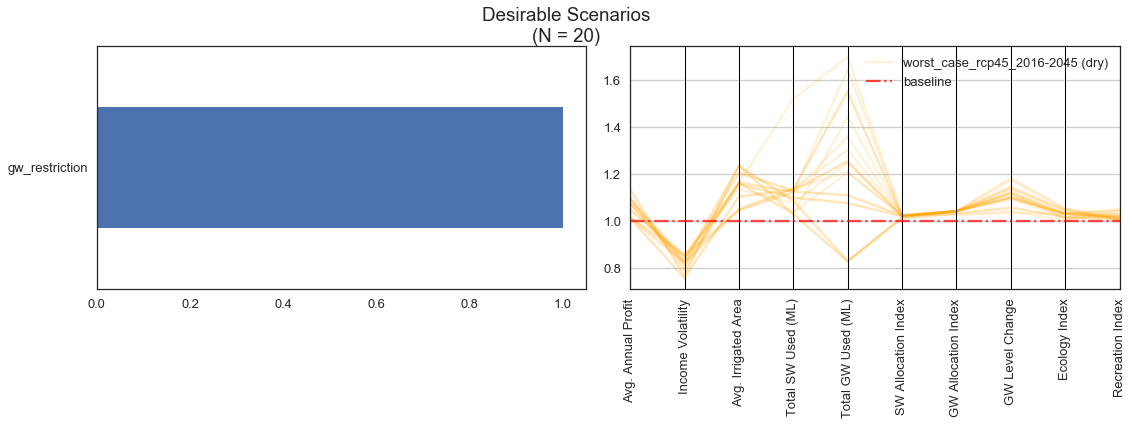

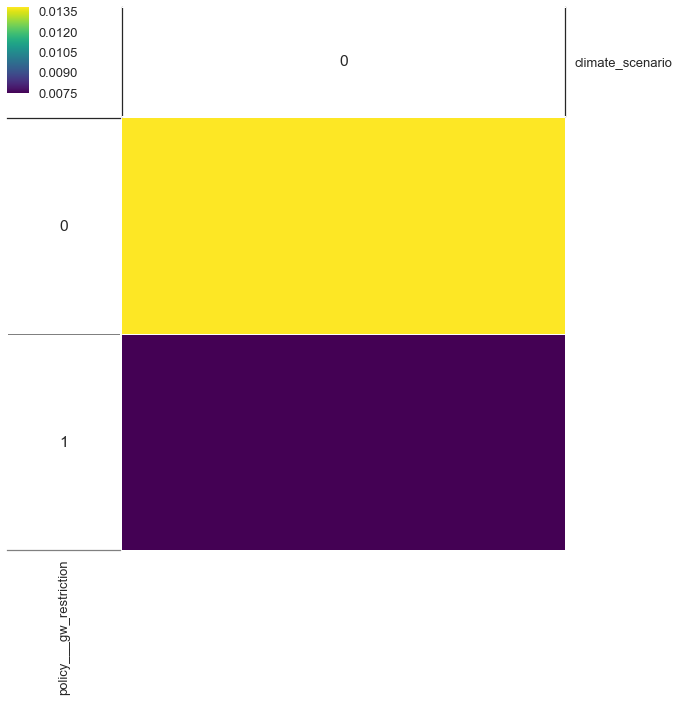

In [37]:
uncontrollable = zone_influences
unneeded = (crop_influences 
            + ['yield_per_Ha', '___water_use_ML', 'pumping_cost', 'Field', 'Irrigation']
            + ['drought_trigger', 'gw_cap', 'allocation_scenario', 'max_drought_years'])

remove_influences = uncontrollable + unneeded

x = remove_unneeded(scenario_inputs, remove_influences)
y = normalized_results.copy()

idx = x.loc[(x['climate_scenario'].str.contains('dry'))
            , :].index

x_tmp = x.loc[idx, :]
x_tmp = to_recs(x_tmp)
y = y.loc[idx, :]

desirable_y = select_desired(y)
plot_scenario_results(x_tmp, y, desirable_y, threshold=0.0)

dimensional_stacking.create_pivot_plot(x_tmp, desirable_y, 2, nbins=2, bin_labels=False);

('Num desirable outcomes: ', 63)


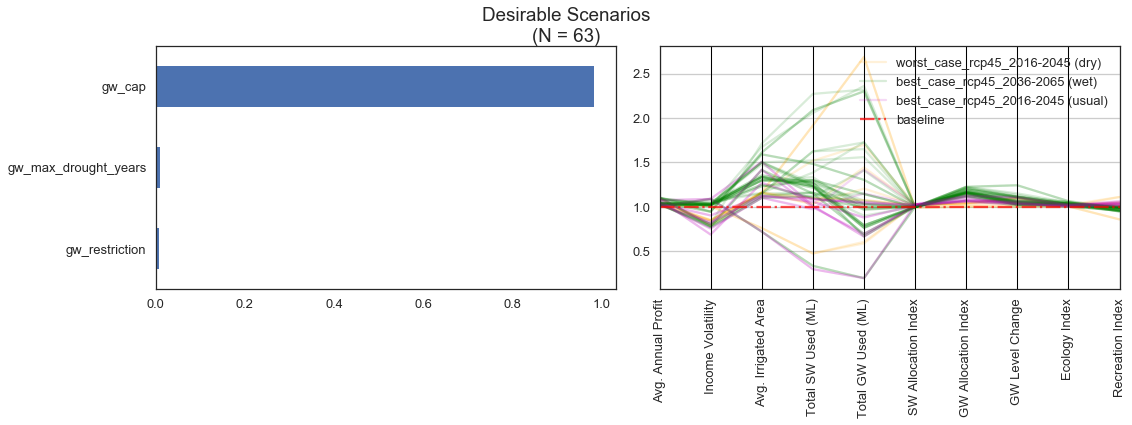

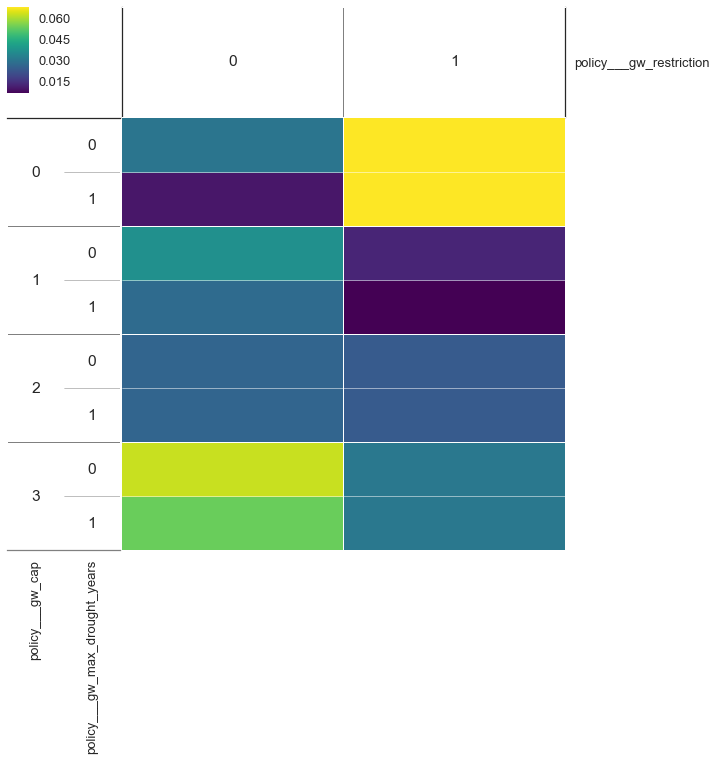

In [38]:
uncontrollable = zone_influences
unneeded = (crop_influences 
            + ['yield_per_Ha', '___water_use_ML', 
               'pumping_cost', 'Field', 'Irrigation', 'drought_trigger'])
            # + ['drought_trigger', 'gw_cap'])

x = remove_unneeded(scenario_inputs, unneeded)
y = normalized_results.copy()

idx = x.loc[(( # (x['policy___goulburn_allocation_scenario'] == 'low') | 
               (x['policy___goulburn_allocation_scenario'] == 'median')))
             # (x['climate_scenario'].str.contains('dry'))
            , :].index

x_tmp = x.loc[idx, :]
y = y.loc[idx, :]

x_tmp = remove_unneeded(x_tmp, ['climate', 'goulburn'])

x_tmp = to_recs(x_tmp)

# y = normalized_results.copy()
desirable_y = select_relaxed(y)

plot_scenario_results(x_tmp, y, desirable_y, threshold=0.0)

dimensional_stacking.create_pivot_plot(x_tmp, desirable_y, 3, nbins=4, bin_labels=False);

('Num desirable outcomes: ', 63)


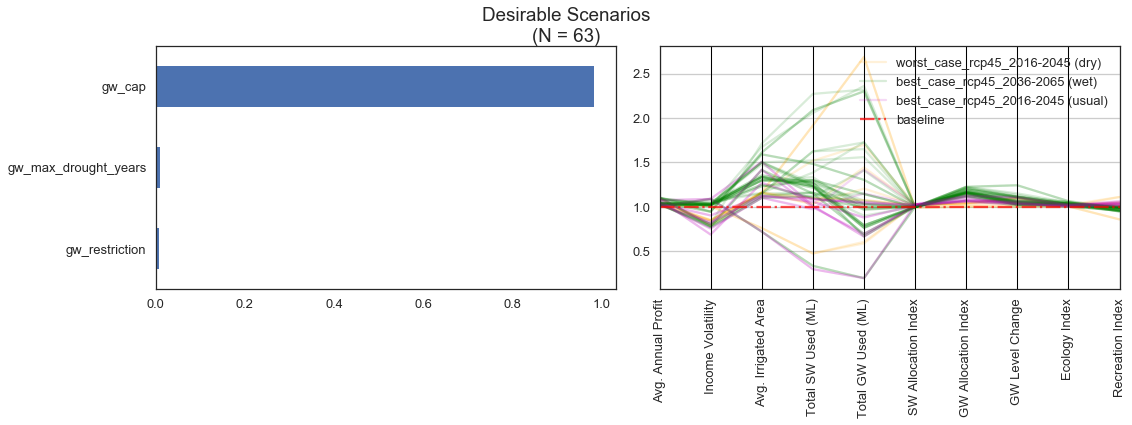

In [39]:
plot_scenario_results(x_tmp, y, desirable_y, threshold=0.0)

('Num desirable outcomes: ', 72)


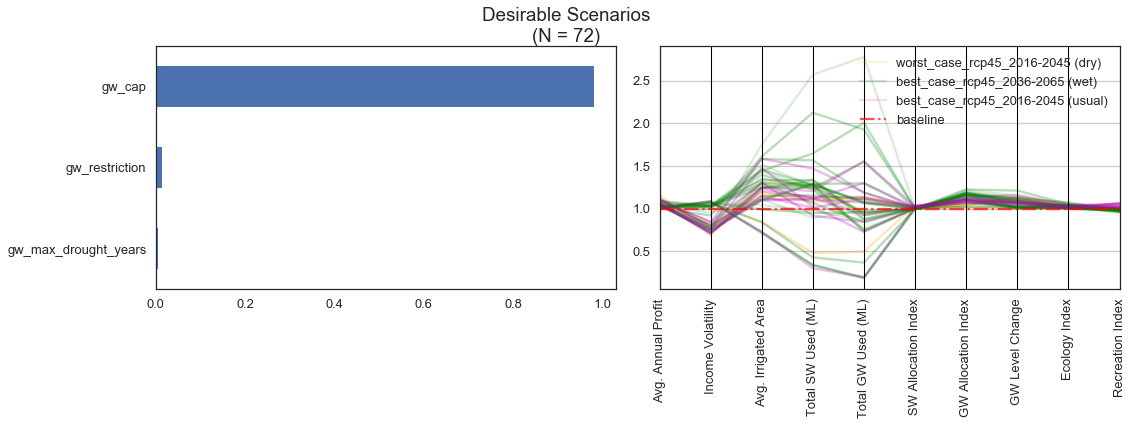

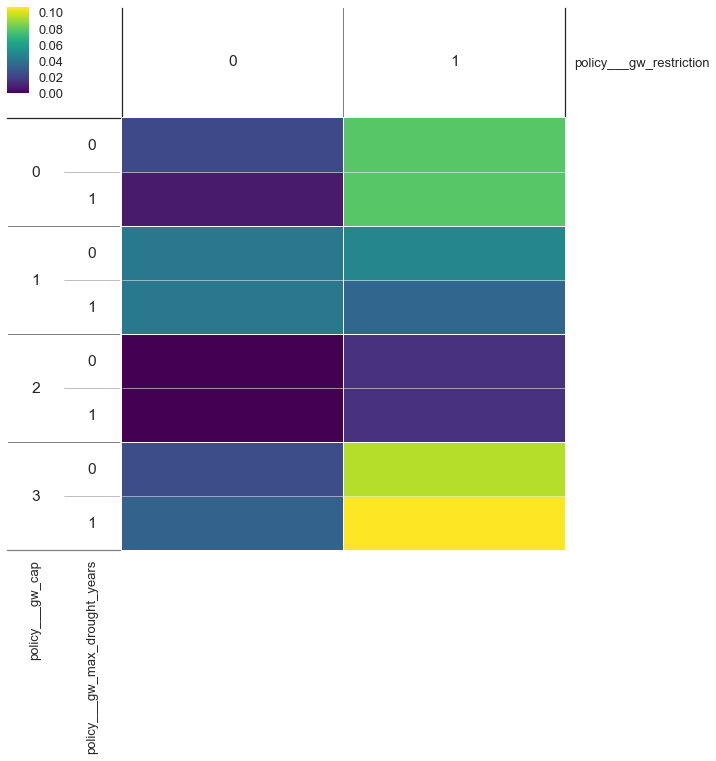

In [40]:
uncontrollable = zone_influences
unneeded = (crop_influences 
            + ['yield_per_Ha', '___water_use_ML', 
               'pumping_cost', 'Field', 'Irrigation', 'drought_trigger'])
            # + ['drought_trigger', 'gw_cap'])

x = remove_unneeded(scenario_inputs, unneeded)
y = normalized_results.copy()

idx = x.loc[(( (x['policy___goulburn_allocation_scenario'] == 'low') )) # | 
#              (x['policy___goulburn_allocation_scenario'] == 'median')))
             # (x['climate_scenario'].str.contains('dry'))
            , :].index

x_tmp = x.loc[idx, :]
y = y.loc[idx, :]

x_tmp = remove_unneeded(x_tmp, ['climate', 'goulburn'])

x_tmp = to_recs(x_tmp)

# y = normalized_results.copy()
desirable_y = select_relaxed(y)

plot_scenario_results(x_tmp, y, desirable_y, threshold=0.0)

dimensional_stacking.create_pivot_plot(x_tmp, desirable_y, 3, nbins=4, bin_labels=False);

In [41]:
gw_cap_data = x_tmp['policy___gw_cap']

pd.cut(gw_cap_data, bins=4, retbins=True)


([(0.7, 0.8], (0.6, 0.7], (0.9, 0.999], (0.7, 0.8], (0.9, 0.999], ..., (0.6, 0.7], (0.8, 0.9], (0.8, 0.9], (0.7, 0.8], (0.7, 0.8]]
 Length: 1872
 Categories (4, interval[float64]): [(0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 0.999]],
 array([ 0.59975713,  0.69996566,  0.79977496,  0.89958426,  0.99939355]))

In [42]:
# x.loc[x.index.difference(desirable_y.index), :]

In [43]:
x = remove_unneeded(scenario_inputs, [])
y = normalized_results.copy()

idx = x.loc[(((x['policy___goulburn_allocation_scenario'] == 'low')))
             & (x['climate_scenario'].str.contains('dry'))
            , :].index

x_tmp = x.loc[idx, :]
y = y.loc[idx, :]
x_tmp = to_recs(x_tmp)

# y = normalized_results.copy()
desirable_y = select_relaxed(y)

# pd.DataFrame(x_tmp[desirable_y])

('Num desirable outcomes: ', 2)


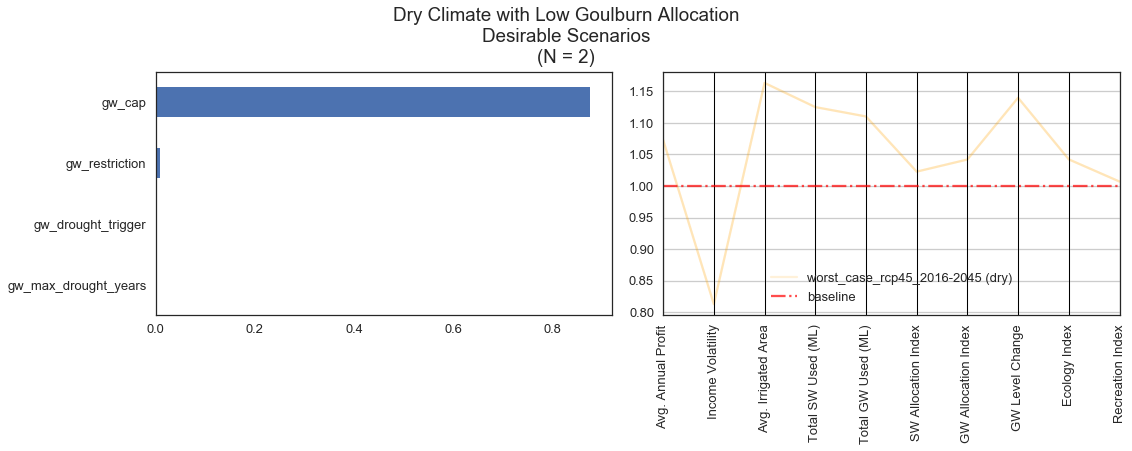

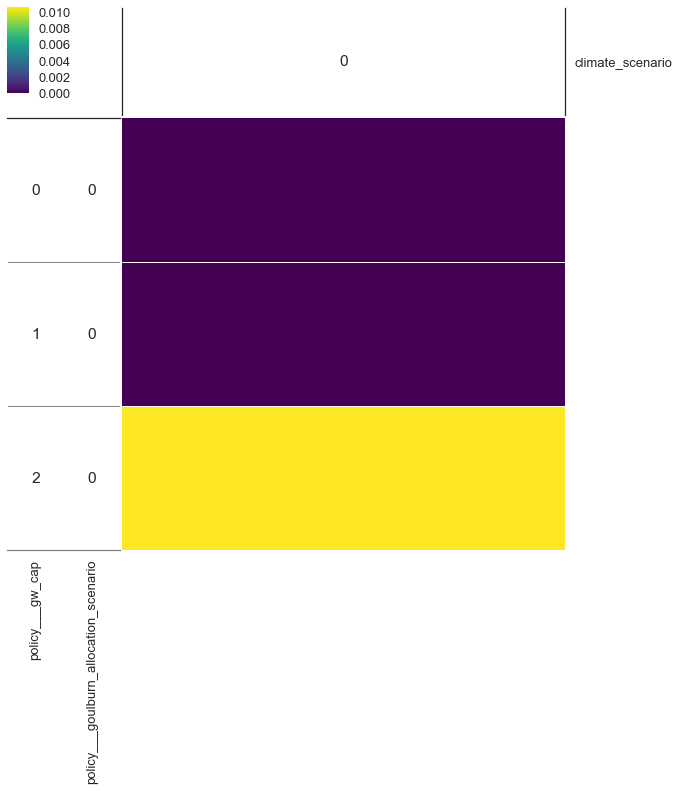

In [44]:
uncontrollable = zone_influences
unneeded = (crop_influences 
            + ['yield_per_Ha', '___water_use_ML', 
               'pumping_cost', 'Field', 'Irrigation'])
            # + ['drought_trigger', 'gw_cap'])

x = remove_unneeded(scenario_inputs, unneeded)
y = normalized_results.copy()

idx = x.loc[(x['policy___goulburn_allocation_scenario'] == 'low')
             & (x['climate_scenario'].str.contains('dry'))
            , :].index

# idx = x.loc[(x['policy___goulburn_allocation_scenario'] == 'low')
#             , :].index

x_tmp = x.loc[idx, :]
y = y.loc[idx, :]

x_subset = remove_unneeded(x_tmp.copy(), ['climate', 'goulburn'])
x_recs = to_recs(x_subset)

# y = normalized_results.copy()
desirable_y = select_desired(y)

plot_scenario_results(x_recs, y, desirable_y, threshold=0.0, 
                      title_prepend='Dry Climate with Low Goulburn Allocation',
                      title_y=1.05
                     )


x_subset = remove_unneeded(x_tmp.copy(), ['trigger', 'max_drought', 'restriction'])
x_recs = to_recs(x_subset)
dimensional_stacking.create_pivot_plot(x_recs, desirable_y, 3, nbins=3, bin_labels=False);


Same as above, but concentrating on dry scenarios

('Num desirable outcomes: ', 2)


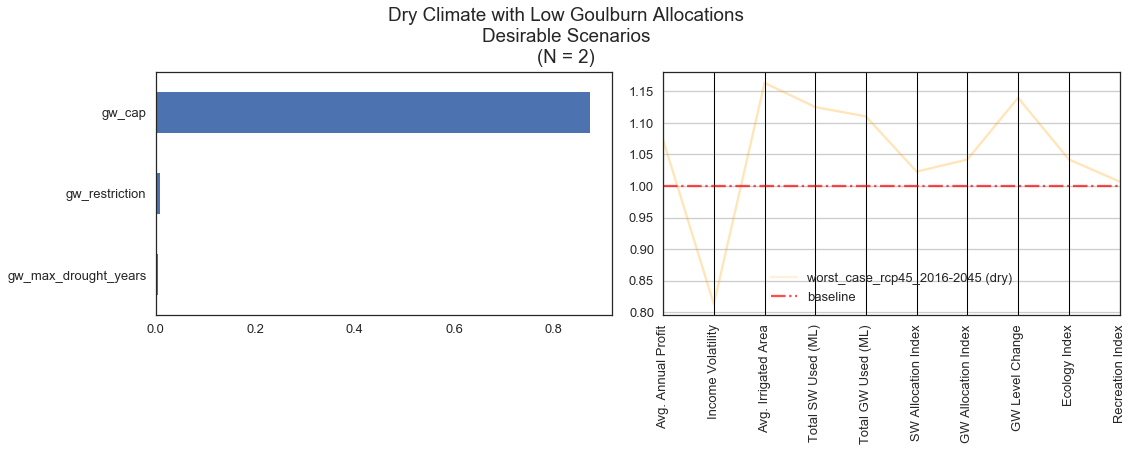

In [45]:
uncontrollable = zone_influences
unneeded = (crop_influences 
            + ['___water_use_ML', 'yield_per_Ha', 
               'Field', 'Irrigation', 'drought_trigger'])

x = remove_unneeded(scenario_inputs, unneeded)
y = normalized_results.copy()

idx = x.loc[(x['policy___goulburn_allocation_scenario'] == 'low') &
             (x['climate_scenario'].str.contains('dry'))
            , :].index

x_tmp = x.loc[idx, :]
y = y.loc[idx, :]

x_tmp = remove_unneeded(x_tmp, ['climate', 'goulburn'])
x_tmp = to_recs(x_tmp)

# y = normalized_results.copy()
desirable_y = select_desired(y)

plot_scenario_results(x_tmp, y, desirable_y, threshold=0.0,
                      save_pth=FIG_PATH+'/test.png', title_prepend='Dry Climate with Low Goulburn Allocations', title_y=1.05)

# dimensional_stacking.create_pivot_plot(x_tmp, desirable_y, 3, nbins=4, bin_labels=False);